In [1]:
# load dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 1. load data

In [14]:
# load data
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
train.shape, test.shape

((10886, 12), (6493, 9))

In [15]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [17]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# 2. Feature Engineering

- Datetime

In [18]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day

train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

train['dayofweek'] = train['datetime'].dt.dayofweek

In [19]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day

test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second

test['dayofweek'] = test['datetime'].dt.dayofweek

In [20]:
train.shape, test.shape

((10886, 19), (6493, 16))

- Windspeed

0: missing value - use RF prediction

0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
51.9987       1
50.0021       1
Name: windspeed, dtype: int64


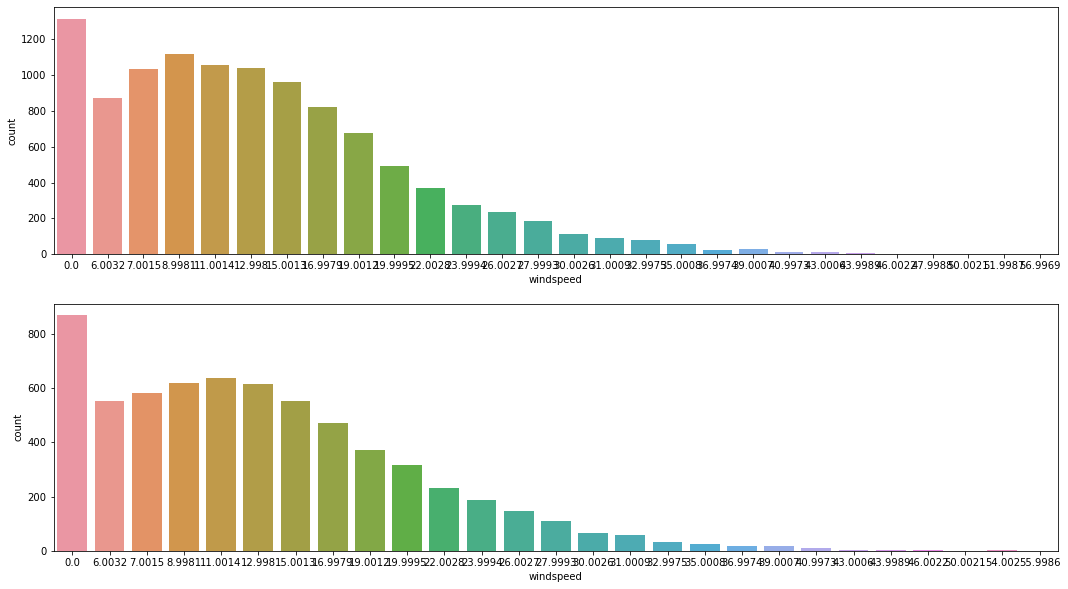

In [21]:
f, ax = plt.subplots(2,1, figsize=(18,10))
print(train['windspeed'].value_counts())
sns.countplot(train['windspeed'], ax=ax[0])
sns.countplot(test['windspeed'], ax=ax[1])
plt.show()

In [22]:
from sklearn.ensemble import RandomForestClassifier
def predict_windspeed(data):
    # 풍속이 0인 것과 아닌것을 나눈다
    dataWind0 = data.loc[data['windspeed']==0]
    dataWindNot0 = data.loc[data['windspeed']!=0]
    
    # 풍속을 예측할 피쳐 선택
    wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']
    
    # 풍속이 0이 아닌 데이터의 타입을 스트링으로 바꾼다
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
    
    # RF 분류기를 사용한다
    rfModel_wind = RandomForestClassifier()
    
    # wCol에 있는 피처의 값을 파탕으로 풍속을 학습한다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    
    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이털의 풍속을 예측한다.
    wind0Value = rfModel_wind.predict(dataWind0[wCol])
    
    # 값을 예측 후 비교해 보기 위해 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다
    predictWind0['windspeed'] = wind0Value
    
    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합친다
    data = predictWindNot0.append(predictWind0)
    
    # 풍속의 데이터타입을 float로 지정
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

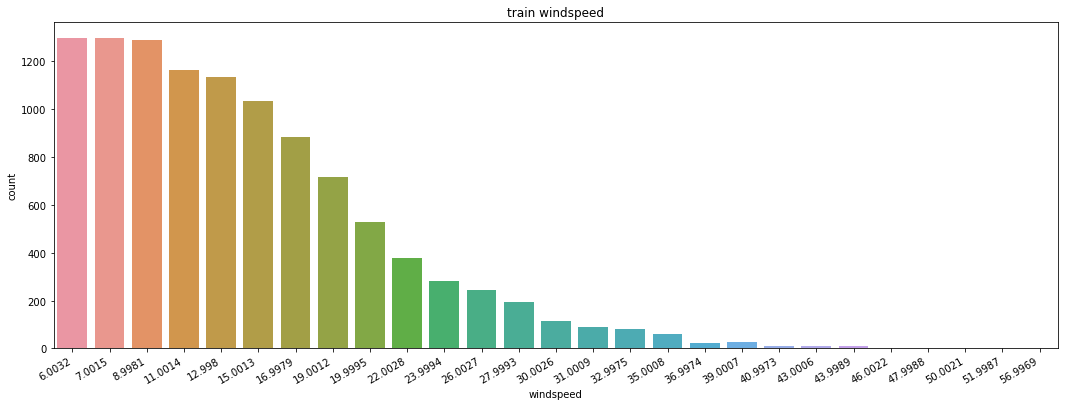

In [23]:
# 0값을 조정
train = predict_windspeed(train)
# test = predict_windspeed(test)

# windspeed의 0값을 조정한 데이터를 시각화
f, ax = plt.subplots(figsize=(18,6))
plt.sca(ax)
plt.xticks(rotation=30, ha='right')
ax.set(ylabel='Count', title='train windspeed')
sns.countplot(x='windspeed', data=train)
plt.show()

# 3. Feature Selection
- 신호와 잡음을 구분해야 한다
- 피처가 많다고 무조건 좋은 성능을 내지 않는다
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다

In [24]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek'],
      dtype='object')

In [27]:
# 연속형 feature와 범주형 feature
# 연속형 feature = ['temp', 'humidity', 'windspeed', 'atemp']
# 범주형 feature의 type을 category로 변경 해 준다
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for var in categorical_features:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')
train.dtypes, test.dtypes

(datetime      datetime64[ns]
 season              category
 holiday             category
 workingday          category
 weather             category
 temp                 float64
 atemp                float64
 humidity               int64
 windspeed            float64
 casual                 int64
 registered             int64
 count                  int64
 year                category
 month               category
 day                    int64
 hour                category
 minute                 int64
 second                 int64
 dayofweek           category
 dtype: object,
 datetime      datetime64[ns]
 season              category
 holiday             category
 workingday          category
 weather             category
 temp                 float64
 atemp                float64
 humidity               int64
 windspeed            float64
 year                category
 month               category
 day                    int64
 hour                category
 minute                 

In [28]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                'year', 'hour', 'dayofweek', 'holiday', 'workingday']

X_train = train[feature_names]
X_test = test[feature_names]

X_train.shape, X_test.shape

((10886, 11), (6493, 11))

In [29]:
X_train.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [30]:
label_name = 'count'

y_train = train[label_name]
y_train.shape

(10886,)

In [31]:
y_train.head()

0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [36]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

# 4. Modeling

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)

model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [40]:
%time cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring=rmsle_scorer)
print('Score={0:.5f}'.format(cv_score.mean()))

CPU times: total: 1.67 s
Wall time: 3.34 s
Score=0.33166


# 5. Random Forest

In [41]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(predictions.shape)
predictions[:10]

(6493,)


array([ 12.44,   5.05,   4.11,   3.54,   3.12,   6.37,  38.39, 105.73,
       237.2 , 135.95])

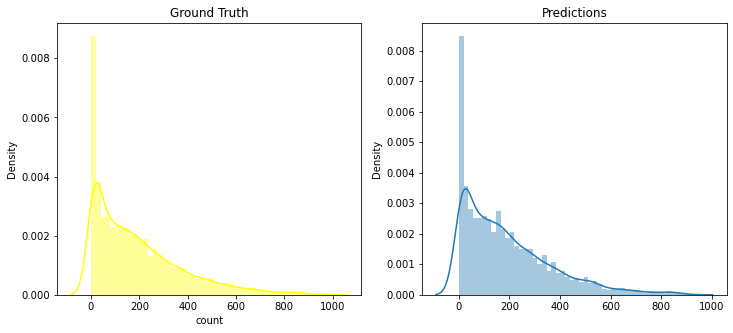

In [47]:
f, ax = plt.subplots(1,2,figsize=(12,5))
sns.distplot(y_train, ax=ax[0], color='yellow', bins=50)
ax[0].set_title("Ground Truth")
sns.distplot(predictions, ax=ax[1], bins=50)
ax[1].set(title='Predictions')
plt.show()